In [2]:
!rm *.fbs *.npy *.json *.bin

rm: cannot remove '*.bin': No such file or directory


In [18]:
# Generate 2 structure flatbuffers
!./converters/StructureGenerator.py -f ./res/posStruc.npy --num_structs 2 --num_orientations 0
!flatc -t converters/schemas/Structure.fbs -- struct_0.fbs --raw-binary --strict-json

Namespace(filename='./res/posStruc.npy', num_structs=1, num_orientations=1, func=<function create_structure_buf_from_args at 0x7fedd1525bd0>)
1
(10, 10, 3)


In [5]:
# generate a parameter config (of interest is defocus [0.5,4,N] where N is number of steps)
# output file to demo_params.fbs
!./converters/ParameterGenerator.py -a [0.1] \
 -d [0.5,4,25] \
 -bf [1.0] \
 -id [7.0,8.0,9] \
 -np [128] \
 -pw [0.3] \
 -s [1.0] \
 -ew [0.019866] \
 -snr [1.0] \
 -ep [25.0,26.0,27] \
 -seed [28.0,29.0,30] \
 -st [31.0,32.0,33] \
 -c [34.0,35.0,36] \
 -o demo_params.fbs

!flatc -t converters/schemas/ParamModel.fbs -- demo_params.fbs --raw-binary --strict-json

[0.1]
[0.5, 4.0, 25.0]
[1.0]
[7.0, 8.0, 9.0]
[128.0]
[0.3]
[1.0]
[0.019866]
[1.0]
[25.0, 26.0, 27.0]
[28.0, 29.0, 30.0]
[31.0, 32.0, 33.0]
[34.0, 35.0, 36.0]
demo_params.fbs


In [19]:
# generate images from struct_0 and output to images_0
!./DataGenerator.py images -p demo_params.fbs -s struct_0.fbs -o images_0.fbs
!flatc -t converters/schemas/DataSet.fbs -- images_0.fbs --raw-binary --strict-json
# !./DataGenerator.py images -p demo_params.fbs -s struct_1.fbs -o images_1.fbs


10
Generating images for batch:   0%|                        | 0/1 [00:00<?, ?it/s]tensor([[[ 5.3060, -3.9180, -5.0120],
         [ 3.5360, -3.5380, -1.6420],
         [ 4.3460, -1.3880,  1.4480],
         [ 3.4160,  2.0920,  0.0480],
         [ 0.7460,  3.2220,  2.5880],
         [-0.7040,  5.4320, -0.3120],
         [-0.8840,  2.1420, -2.3120],
         [-3.9540,  1.3820, -0.1220],
         [-4.4440, -1.9380,  1.6780],
         [-7.3640, -3.4880,  3.6380]],

        [[ 1.6003, -3.3183,  7.4198],
         [ 1.4142, -3.5648,  3.6068],
         [-1.5075, -4.3726,  1.2323],
         [-3.5175, -1.0899,  1.5770],
         [-3.6412,  0.0905, -2.0903],
         [-3.9816,  3.7200, -0.6386],
         [-0.7246,  2.9306,  1.2654],
         [ 0.9872,  3.4662, -2.1377],
         [ 3.5194,  1.0208, -3.5906],
         [ 5.8513,  1.1175, -6.6440]]], dtype=torch.float64)
Generating images for batch: 100%|███████████████| 1/1 [00:00<00:00, 143.18it/s]


In [7]:
# generate ctfs using the demo parameters
!./DataGenerator.py ctfs -p demo_params.fbs

ctfs_wrapper
torch.Size([25, 128, 128])


In [10]:
# synthesize images_0 using ctfs and output all generated permutations with leading tag STRUCT0
!./DataGenerator.py synth -i images_0.fbs -c ctfs.fbs -o STRUCT0
!./DataGenerator.py synth -i images_1.fbs -c ctfs.fbs -o STRUCT1
# from res.inspector import *

In [20]:
# convert any dataset flatbuffer to numpy array of complex values
from res.inspector import *
# from DataGenerator import *
# filename structure := TAG_synth_dataset_ID.fbs
serialize_fbs_dataset("STRUCT0_synth_dataset_0.fbs")
serialize_fbs_dataset("STRUCT1_synth_dataset_0.fbs")

serialize_fbs_dataset("images_0.fbs")
serialize_fbs_dataset("images_1.fbs")

TypeError: Invalid shape (25, 128, 128) for image data

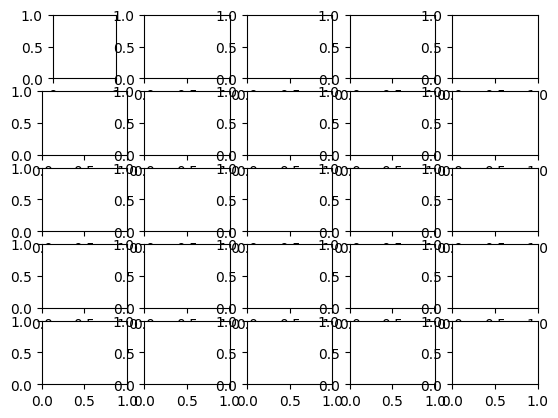

In [4]:
# peek at the files
f =["serialized_STRUCT0_synth_dataset_0.npy", "serialized_files.npy", "images"]
ID = 1
import matplotlib.pyplot as plt
serialized_synth_imgs = np.load(f[ID])
serialized_imgs = np.load(f[ID])
r,c = 5,5
fig, axes = plt.subplots(r, c)
for i in range(r):
    for j in range(c):
      axes[i,j].imshow(np.real(serialized_synth_imgs[i * r + j]))
axes[r-1,c-1].imshow(np.real(serialized_imgs[0]), cmap="gray")

plt.show()

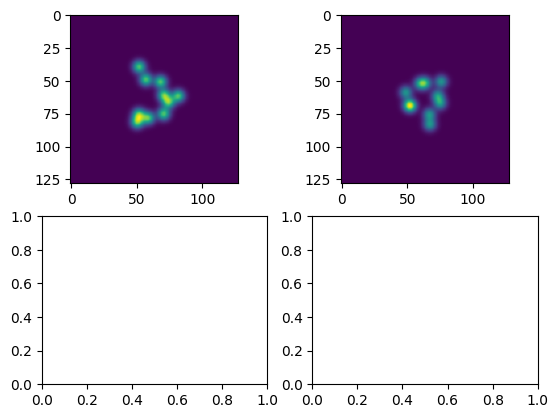

In [21]:
img_0 = np.load("serialized_images_0.npy")
img_1 = np.load("serialized_images_0.npy")
r,c = 5,5
fig, axes = plt.subplots(2, 2)
axes[0,0].imshow(np.real(img_0[0]))
axes[0,1].imshow(np.real(img_1[1]))

plt.show()

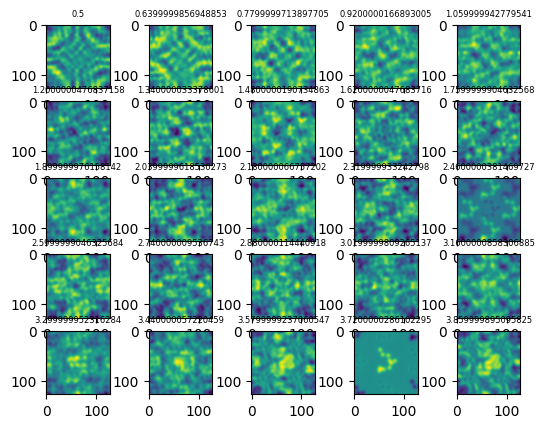

In [72]:
ctf_paramSet_buf = ParametersT.InitFromObj(
    DataSet.GetRootAsDataSet(dl.load_flatbuffer("ctfs.fbs"), 0).Params()
)
serialized_ctfs = np.load("serialized_STRUCT0_synth_dataset_0.npy")

row = 5
col = 5
f = 0
fig, axes = plt.subplots(row, col)
for i in range(row):
    for j in range(col):
        # print())
        axes[i, j].imshow(np.real(np.fft.fftshift(serialized_ctfs[(i + f) * row + j])))
        # axes[i,j].imshow(get_phase(np.fft.fftshift(b[(i+f)*row+j]),128),cmap="Greys")
        axes[i, j].set_title(f"{ctf_paramSet_buf.defocus[(i+f)*row+j]}", fontsize=6)